In [3]:
from f3dasm import ExperimentData
import numpy as np
from pathlib import Path
import pandas as pd
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures # For Polynomial basis functions
from sklearn.pipeline import make_pipeline # to link different objects
from matplotlib import cm # to change colors of surface plots
import matplotlib.pyplot as plt # import plotting tools to create figures

In [4]:
df_in_7d = pd.read_csv('data/supercompressible_7d_input.csv')
df_out_7d = pd.read_csv('data/supercompressible_7d_output.csv')

df_in_3d = pd.read_csv('data/supercompressible_3d_input.csv')
df_out_3d = pd.read_csv('data/supercompressible_3d_output.csv')

In [5]:
X_3d = df_in_3d.loc[:, ['ratio_d','ratio_pitch','ratio_top_diameter'] ].values
Y_3d_class = df_out_3d.loc[:, 'coilable'].values
Y_3d_reg = df_out_3d.loc[:,['sigma_crit','energy']].values

In [6]:
from sklearn.model_selection import train_test_split
testset_ratio = 0.25
SEED = 123
X_3d_train, X_3d_test, Y_3d_class_train, Y_3d_class_test = train_test_split(X_3d,
                                    Y_3d_class, test_size=testset_ratio,
                                    random_state=SEED)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_3d_train)
X_3d_train_scale=scaler.transform(X_3d_train)
X_3d_test_scale=scaler.transform(X_3d_test)
X_3d_scale=scaler.transform(X_3d)

In [7]:
from sklearn import svm
# we create an instance of SVM and fit out data. We did not scale our data (this dataset is quite simple)

SVM_model = svm.SVC(kernel='rbf',gamma=0.7,C=1.0) # - kernel like in GPs
                                                    # - gamma is the kernel hyperparameter (here: length-scale)
                                                    # - C is a l2 regularization parameter (strength of 
                                                    #   regularization is inversely proportional to C)

SVM_model.fit(X_3d_train_scale, Y_3d_class_train) # HERE WE ARE USING ONLY 2 FEATURES TO FIT THE MODEL!
                                           # This is just to assess the predictive power of the SVC even though
                                           #  it is only using 2 features for training.
                                           # REMEMBER: WE USUALLY USE ALL FEATURES WHEN TRAINING A MODEL.

SVC(gamma=0.7)

In [8]:
from sklearn.metrics import accuracy_score
y_class_SVM_pred_test = SVM_model.predict(X_3d_test_scale)
accuracy_score(Y_3d_class_test,y_class_SVM_pred_test)

0.816

In [9]:
x1, x2, x3 = X_3d_scale[:, 0], X_3d_scale[:, 1], X_3d_scale[:,2]

x1_data_min, x1_data_max = x1.min() - 0.005, x1.max() + 0.005 # define min & max of feature 0
x2_data_min, x2_data_max = x2.min() - 0.005, x2.max() + 0.005 # define min & max of feature 0
#x3_data_min, x3_data_max = x3.min() - 0.005, x3.max() + 0.005 # define min & max of feature 0

plot_step = 5e-2 # defining the meshgrid step size

X1_data_grid, X2_data_grid = np.meshgrid(np.arange(x1_data_min, x1_data_max, plot_step),
                                         np.arange(x2_data_min, x2_data_max, plot_step))

len(np.arange(x1_data_min, x1_data_max, plot_step))
len(np.arange(x2_data_min, x2_data_max, plot_step))

X1_data_space = np.zeros((len(np.arange(x1_data_min, x1_data_max, plot_step)),len(np.arange(x2_data_min, x2_data_max, plot_step)),len(x3)))
X2_data_space = np.zeros((len(np.arange(x1_data_min, x1_data_max, plot_step)),len(np.arange(x2_data_min, x2_data_max, plot_step)),len(x3)))
X3_data_space = np.zeros((len(np.arange(x1_data_min, x1_data_max, plot_step)),len(np.arange(x2_data_min, x2_data_max, plot_step)),len(x3)))

for i in range(len(np.arange(x1_data_min, x1_data_max, plot_step))):
    for j in range(len(np.arange(x2_data_min, x2_data_max, plot_step))):
        for k in range(len(x3)):
            X1_data_space[i,j,k] = X1_data_grid[j,i]
            X2_data_space[i,j,k] = X2_data_grid[j,i]
            X3_data_space[i,j,k] = x3[k]

y_class_SVM_pred_disp = SVM_model.predict(np.c_[X1_data_space.ravel(), X2_data_space.ravel(), X3_data_space.ravel()])
y_class_SVM_pred_disp_grid = y_class_SVM_pred_disp.reshape(X1_data_space.shape)


Text(0.5, 1.0, 'Support Vector Machine Classifier (SVC) with RBF kernel with ratio_top_diameter')

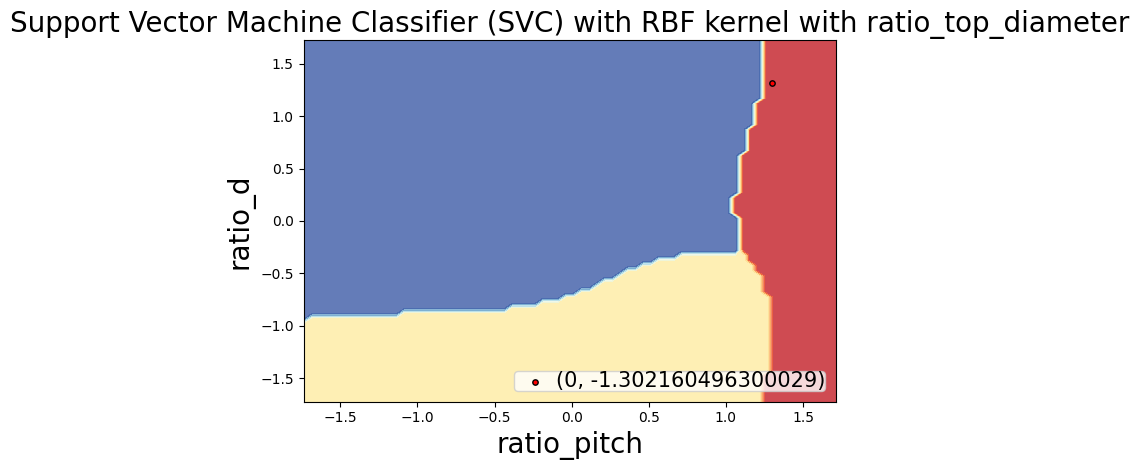

In [10]:
temp_sample = 5
temp_disp = y_class_SVM_pred_disp_grid[:,:,temp_sample]
temp_x1 = X1_data_space[:,:,temp_sample]
temp_x2 = X2_data_space[:,:,temp_sample]
temp_x3 = x3[temp_sample]

plot_colors = 'ryb' # defining the 3 colors for each category
n_classes = 3
target_names = ['Not coilable','coilable','coilable but yield']

fig2, ax2 = plt.subplots(tight_layout=True)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax2.contourf(temp_x2, temp_x1, temp_disp, cmap=cm.RdYlBu, alpha=0.8)

# Plot the training points
ax2.scatter(X_3d_scale[temp_sample, 1], X_3d_scale[temp_sample, 0], c=plot_colors[Y_3d_class[temp_sample]],
                label=(Y_3d_class[temp_sample],X_3d_scale[temp_sample, 2]), edgecolor='black', s=15)

ax2.set_ylim(temp_x1.min(), temp_x1.max())
ax2.set_xlim(temp_x2.min(), temp_x2.max())
ax2.set_ylabel('ratio_d', fontsize=20)
ax2.set_xlabel('ratio_pitch', fontsize=20)
#ax2.set_xticks(())
#ax2.set_yticks(())
ax2.legend(loc='lower right', borderpad=0, handletextpad=0, fontsize=15)
ax2.set_title('Support Vector Machine Classifier (SVC) with RBF kernel with ratio_top_diameter', fontsize=20)

#plt.close(fig2)

In [11]:

df_out_3d    

,Unnamed: 0,coilable,sigma_crit,energy
0,0,1,0.000494,0.000280
1,1,0,NaN,NaN
2,2,2,23.052002,14.285320
3,3,0,0.693775,NaN
4,4,1,2.887962,NaN
...,...,...,...,...
995,995,0,NaN,NaN
996,996,1,4.968690,2.928651
997,997,2,50.932128,31.343168
998,998,2,20.329816,NaN


In [12]:
df_3d = pd.concat([df_in_3d, df_out_3d], axis=1)

# look at the # of missing points in the first ten columns
df_3d_drop_nan = df_3d.dropna()

X_3d_regression = df_3d_drop_nan.loc[:, ['ratio_d','ratio_pitch','ratio_top_diameter'] ].values
Y_3d_regression_sigma = df_3d_drop_nan.loc[:, ['sigma_crit'] ].values
Y_3d_regression_energy = df_3d_drop_nan.loc[:, ['energy'] ].values


X_3d_train_regression, X_3d_test_regression, Y_3d_train_regression_sigma, Y_3d_test_regression_sigma, Y_3d_train_regression_energy, Y_3d_test_regression_energy = train_test_split(X_3d_regression,
                                    Y_3d_regression_sigma,Y_3d_regression_energy, test_size=testset_ratio,
                                    random_state=SEED)

scaler_regression_x = StandardScaler()
scaler_regression_x.fit(X_3d_train_regression)
X_3d_train_regression_scale=scaler_regression_x.transform(X_3d_train_regression)
X_3d_test_regression_scale=scaler_regression_x.transform(X_3d_test_regression)
X_3d_regression_scale=scaler_regression_x.transform(X_3d_regression)

scaler_regression_sigma_y = StandardScaler()
scaler_regression_sigma_y.fit(Y_3d_train_regression_sigma)
Y_3d_train_regression_sigma_scale=scaler_regression_sigma_y.transform(Y_3d_train_regression_sigma)
Y_3d_test_regression_sigma_scale=scaler_regression_sigma_y.transform(Y_3d_test_regression_sigma)
Y_3d_regression_sigma_scale=scaler_regression_sigma_y.transform(Y_3d_regression_sigma)

scaler_regression_energy_y = StandardScaler()
scaler_regression_energy_y.fit(Y_3d_train_regression_energy)
Y_3d_train_regression_energy_scale=scaler_regression_energy_y.transform(Y_3d_train_regression_energy)
Y_3d_test_regression_energy_scale=scaler_regression_energy_y.transform(Y_3d_test_regression_energy)
Y_3d_regression_energy_scale=scaler_regression_energy_y.transform(Y_3d_regression_energy)

In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, ConstantKernel, WhiteKernel
kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=2.5)

gp_model_sigma = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)
gp_model_sigma.fit(X_3d_train_regression_scale, Y_3d_train_regression_sigma_scale)

gp_model_energy = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)
gp_model_energy.fit(X_3d_train_regression_scale, Y_3d_train_regression_energy_scale)

from sklearn.metrics import r2_score, mean_squared_error

y_3d_test_pred_sigma, sigma = gp_model_sigma.predict(X_3d_test_regression_scale, return_std=True) # also output the uncertainty (std)
r2_sigma = r2_score(Y_3d_test_regression_sigma_scale,y_3d_test_pred_sigma)
mse_sigma = mean_squared_error(Y_3d_test_regression_sigma_scale,y_3d_test_pred_sigma)

print(r2_sigma)
print(mse_sigma)

y_3d_test_pred_energy, sigma = gp_model_sigma.predict(X_3d_test_regression_scale, return_std=True) # also output the uncertainty (std)
r2_energy = r2_score(Y_3d_test_regression_energy_scale,y_3d_test_pred_energy)
mse_energy = mean_squared_error(Y_3d_test_regression_energy_scale,y_3d_test_pred_energy)

print(r2_energy)
print(mse_energy)

0.9998109921879373
0.00017083324705044622
0.9953722499511284
0.004314007908032823
